In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, LSTM, GRU, SpatialDropout1D, Bidirectional, BatchNormalization
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.layers as layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, roc_auc_score, auc, f1_score
from IPython.display import display
import tensorflow.keras.metrics as metrics 
import tensorflow_addons.metrics as tfa_metrics
from keras import backend as K
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

In [3]:
def create_tokenizer(list_text):
    
    tokenizer = text.Tokenizer()
    tokenizer.fit_on_texts(list_text)
    
    return tokenizer
def encode_data(tokenizer : text.Tokenizer, X, maxlen):
    
    seq = tokenizer.texts_to_sequences(X)
    pad = sequence.pad_sequences(seq, maxlen=maxlen)
    
    return pad

def convert_probabilities_to_predictions(probabilities):
    predictions = [np.rint(x) for x in probabilities]
    return predictions

def make_prediction(model, X, tokenizer):
    
    X_encoded = encode_data(tokenizer,X)
    probabilities = model.predict(X_encoded)
    predictions = convert_probabilities_to_predictions(probabilities)
    
    return predictions

def load_data(train_data_path, test_data_path):
    train_data = pd.read_csv(train_data_path)
    test_data = pd.read_csv(test_data_path)
    
    return train_data, test_data

In [4]:
logs = []

def add_log(hyperparameters, metrics, histories):
    logs.append((hyperparameters.copy(), metrics.copy(), histories.copy()))
    
def display_log():
    for count,(hyperparameters,metrics, histories) in enumerate(logs):
        print(f'Logs : Run {count}')
        print(f'------------------')
#         print(hyperparameters)
        for key in hyperparameters.keys():
            print(f'{key} : {hyperparameters[key]}')
        metrics_df = pd.DataFrame(metrics)
        display(metrics_df.style.background_gradient(cmap='OrRd'))
        
        
    for count,(hyperparameters,metrics, histories) in enumerate(logs):
        for optimizer_name in histories.keys():
            m_dic = histories[optimizer_name]

            for model_name in m_dic.keys():
                history = m_dic[model_name]

                df_history = pd.DataFrame(m_dic[model_name]['History'].history)

                df_loss = df_history[['loss','val_loss']]
                df_accuracy = df_history[['accuracy', 'val_accuracy']]

                fig, axes = plt.subplots(1,2, dpi=100, figsize=(10,3), facecolor='white')
                fig.suptitle(f'{optimizer_name} - {model_name}')

                df_loss.plot(ax = axes[0])
                df_accuracy.plot(ax = axes[1])
                
#         print(f'-------------------------------------------------------------------------')
    

In [5]:
def impute(dataset : pd.DataFrame):
    dataset_copy = dataset.copy()
    dataset_copy['keyword'].fillna('0', inplace=True)
    dataset_copy['keyword'] = dataset_copy['keyword'].str.split('%20').str.join(',')
    
    return dataset_copy

## Load Data

In [6]:
train_data, test_data = load_data('../input/nlp-getting-started/train.csv',
                                 '../input/nlp-getting-started/test.csv')

#Filled keyword column for missing values and split values with '%20' and joined them together with ',' delimiter.
train_data = impute(train_data) 
test_data = impute(test_data)


#Using the train_data, split it into train and valid sets
X_train, X_valid, y_train, y_valid = train_test_split(train_data[['text', 'keyword']],
                                                      train_data.target,   
                                                      train_size=0.9, 
                                                      random_state=1,
                                                      shuffle=True)

#Converted dataframe to numpy since I got errors while trying to train the model.
y_train = y_train.to_numpy()
y_valid = y_valid.to_numpy()

train_text = X_train['text'].to_numpy()
valid_text = X_valid['text'].to_numpy()
test_text = test_data['text'].to_numpy()

train_keyword = X_train['keyword'].to_numpy()
valid_keyword = X_valid['keyword'].to_numpy()
test_keyword = test_data['keyword'].to_numpy()

In [7]:
# Creates a tokenizer
tokenizer_text = create_tokenizer(list(train_text) + list(valid_text))
tokenizer_keyword = create_tokenizer(list(train_keyword)+ list(valid_keyword))
# Encoded data in 'text' column in train data
train_text_pad = encode_data(tokenizer_text, np.array(train_text), 200)
valid_text_pad = encode_data(tokenizer_text, np.array(valid_text),200)
test_text_pad = encode_data(tokenizer_text, np.array(test_text),200)

# Encoded data in 'keyword' column in train data
train_keyword_pad = encode_data(tokenizer_keyword, np.array(train_keyword),200)
valid_keyword_pad = encode_data(tokenizer_keyword, np.array(valid_keyword),200)
test_keyword_pad = encode_data(tokenizer_keyword, np.array(test_keyword),200)

In [8]:
print('Details')
print('-------')
print(f'Train-Keyword-Pad (Shape) : {train_keyword_pad.shape}')
print(f'Train-Text-Pad (Shape) : {train_text_pad.shape}')
print('-----------------------------------------------------')
print(f'Valid-Keyword-Pad (Shape) : {valid_keyword_pad.shape}')
print(f'Valid-Text-Pad (Shape) : {valid_text_pad.shape}')
print('-----------------------------------------------------')
print(f'Test-Keyword-Pad (Shape) : {test_keyword_pad.shape}')
print(f'Test-Text-Pad (Shape) : {test_text_pad.shape}')

Details
-------
Train-Keyword-Pad (Shape) : (6851, 200)
Train-Text-Pad (Shape) : (6851, 200)
-----------------------------------------------------
Valid-Keyword-Pad (Shape) : (762, 200)
Valid-Text-Pad (Shape) : (762, 200)
-----------------------------------------------------
Test-Keyword-Pad (Shape) : (3263, 200)
Test-Text-Pad (Shape) : (3263, 200)


## Hypertuning Optimizers

In [9]:
# This area is for fine-tuning the optimizers

hyperparameters = {
                   'epsilon' : 0.1,
                  'initial_learning_rate' : 0.1,
                  'decay_steps' : 500,
                  'decay_rate': 0.5
                }

learning_rate_scheduler = tf.keras.optimizers.schedules.InverseTimeDecay(
    hyperparameters['initial_learning_rate'],
    hyperparameters['decay_steps'],
    hyperparameters['decay_rate'],
    staircase=False, 
    name=None
)


adam = tf.keras.optimizers.Adam(
    learning_rate=learning_rate_scheduler, 
    beta_1=0.9, 
    beta_2=0.999, 
    epsilon=hyperparameters['epsilon'], 
    name="Adamax"
)


In [10]:
input_text = tf.keras.Input( shape=(None,), name='text')
input_keyword = tf.keras.Input(shape=(None,), name='keyword')

text_feature_extraction = Embedding(len(tokenizer_text.word_index) + 1, 512) (input_text)
X_text_lstm = layers.SpatialDropout1D(0.3)(text_feature_extraction)
X_text_lstm = LSTM(512, dropout=0.3, return_sequences=True)(X_text_lstm)
X_text_lstm = LSTM(512,dropout=0.3)(X_text_lstm)


keyword_feature_extraction = Embedding(len(tokenizer_keyword.word_index) + 1, 64) (input_keyword)
X_keyword_lstm = layers.SpatialDropout1D(0.3)(keyword_feature_extraction)
X_keyword_lstm = LSTM(64,dropout=0.3, return_sequences=True)(X_keyword_lstm)
X_keyword_lstm = LSTM(64,dropout=0.3)(X_keyword_lstm)

X = layers.concatenate([X_text_lstm, X_keyword_lstm])
outputs = layers.Dense(1, activation='sigmoid')(X)

model = Model(inputs=[input_text, input_keyword], outputs =outputs )

2022-03-24 14:00:56.505195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 14:00:56.602779: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 14:00:56.603475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 14:00:56.604696: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
keyword (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 512)    11622912    text[0][0]                       
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     14784       keyword[0][0]                    
______________________________________________________________________________________________

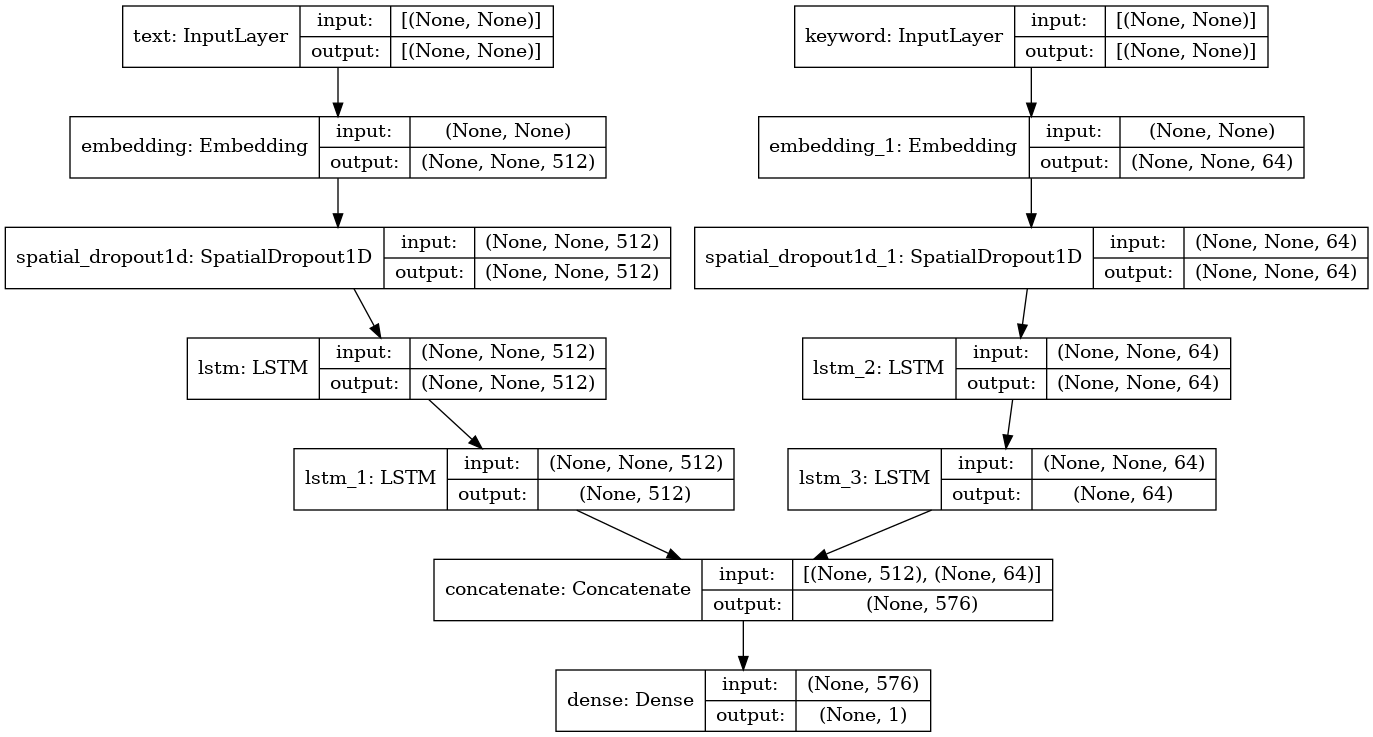

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Model used for Submission

In [13]:
model.compile(optimizer=adam, loss='binary_crossentropy', 
                  metrics=['accuracy', f1]
                 )

callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    
history = model.fit((train_text_pad, train_keyword_pad), y_train, 
                  validation_data=((valid_text_pad, valid_keyword_pad), y_valid),
                 callbacks=callback,
                epochs=300, 
                batch_size=32
                )

2022-03-24 14:01:01.026587: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300


2022-03-24 14:01:07.070556: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


215/215 [==============================] - 29s 104ms/step - loss: 0.6715 - accuracy: 0.5806 - f1: 0.1718 - val_loss: 0.6729 - val_accuracy: 0.5748 - val_f1: 0.0000e+00
Epoch 2/300
215/215 [==============================] - 21s 98ms/step - loss: 0.6429 - accuracy: 0.6274 - f1: 0.4674 - val_loss: 0.6254 - val_accuracy: 0.6654 - val_f1: 0.6001
Epoch 3/300
215/215 [==============================] - 21s 98ms/step - loss: 0.5910 - accuracy: 0.6900 - f1: 0.5969 - val_loss: 0.5616 - val_accuracy: 0.7231 - val_f1: 0.5738
Epoch 4/300
215/215 [==============================] - 21s 98ms/step - loss: 0.5383 - accuracy: 0.7405 - f1: 0.6455 - val_loss: 0.5491 - val_accuracy: 0.7520 - val_f1: 0.6647
Epoch 5/300
215/215 [==============================] - 21s 98ms/step - loss: 0.4554 - accuracy: 0.7981 - f1: 0.7304 - val_loss: 0.4932 - val_accuracy: 0.7769 - val_f1: 0.7104
Epoch 6/300
215/215 [==============================] - 21s 99ms/step - loss: 0.3858 - accuracy: 0.8370 - f1: 0.7816 - val_loss: 0.51

In [14]:
probabilities = model.predict((valid_text_pad, valid_keyword_pad))
predictions = convert_probabilities_to_predictions(probabilities)

score = f1_score(y_valid, predictions)
score

0.7388316151202748

In [15]:
submission = pd.DataFrame()
submission['id'] = test_data['id']

probabilities = model.predict((test_text_pad, test_keyword_pad))
predictions = convert_probabilities_to_predictions(probabilities)

submission['target'] = predictions
submission['target'] = submission['target'].astype(int)

submission

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [16]:
submission.to_csv('submission.csv', index=False)

In [17]:
s = pd.read_csv('submission.csv')
s

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1
